# Applying regression

- **New hypothesis**
  - The relative abundances of microbial phyla in certain types of cryospheric environments are sufficiently unique that phylum-level taxonomic profiles can be used to determine whether or not a given sample belongs the environment or not.
- Since my hypothesis is about categorizing datasets, logistic regression is the natural choice
  - I was able to group several of the sampling sites in my dataset into the categories of "permafrost", "glacier" and "other" based on where they were collected from.
  - The model I develop therefore aims to answer the following question
    - "Based on this phylum-level taxonomic profile, does the sample come from a permafrost OR glacier environment?"
- In the following R snippet, I load in the operational taxonomic unit (OTU) frequency tables into R, their taxonomic classifications using qiime's sklearn classifier and the site metadata
  - These tables are merged together, and the taxonomy is collapsed to the phylum level (the second highest taxonomic rank). Any OTUs with only Kingdom-level identifications are dropped, and all OTUs belonging to the same phylum have their counts combined together
  - Next, the merged frequency table is converted into relative abundances from absolute abundances by dividing each frequency by the sum for that phylum
- At this point, the merged table is in "species x site" format, so I tranpose it before exporting it as a new csv file for python


```r
library(qiime2R)
library(tidyverse)

merge_with_id <- function(otu_table, taxonomy, level) {
    # Merge an otu table with a taxonomy table, keeping only identified taxa
    known <- lapply(1:nrow(taxonomy), known_taxon,
        taxonomy = taxonomy,
        level = level
    ) %>%
        unlist() %>%
        data.frame(row.names = rownames(taxonomy), taxon = .) %>%
        merge(., otu_table, by = 0)
    return(subset(known, select = -c(Row.names)))
}

rel_abund <- function(abs_abund, first_col) {
    rel_abund <- data.frame(first_col = abs_abund[1])
    for (col in 2:ncol(abs_abund)) {
        rel_abund[colnames(abs_abund[col])] <- abs_abund[col] / sum(abs_abund[col])
    }
    return(rel_abund)
}

all <- read_qza("./results/2-OTUs/Merged-otuFreqs.qza")$data
sk_merged <- read_qza("./results/3-Classified/Merged-Sklearn.qza")$data %>%
    parse_taxonomy()

phyla <- merge_with_id(all, sk_merged, level = 2) %>%
    filter(!(is.na(taxon))) %>%
    group_by(taxon) %>%
    summarise(across(everything(), sum))

to_log <- phyla %>%
    as.data.frame() %>%
    t() %>%
    as.data.frame() %>%
    rename_with(~ as.character(as.vector(phyla$taxon)), all_of(colnames(.))) %>%
    mutate(ids = rownames(.)) %>%
     filter(!(ids == "taxon"))  %>%
    inner_join(metadata, ., by = join_by(x$sample.id == y$ids)) %>%
    as_tibble()
write.csv(to_log, "logistic_reg.csv", row.names = FALSE)
```


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
phyla = pd.read_csv("./logistic_reg.csv").drop("sample.id", axis="columns")
display(phyla)

,Location,Type,Abditibacteriota,Acidobacteriota,Actinobacteriota,Altiarchaeota,AncK6,Armatimonadota,Arthropoda,Ascomycota,...,Sva0485,Synergistota,TA06,Thermoplasmatota,Verrucomicrobiota,WPS-2,WS1,WS2,WS4,Zixibacteria
0,Barrow Alaska Low,Permafrost,0.000000,0.078242,0.055966,0.0,0.0,0.002271,0.0,0.0,...,0.000146,0.001281,0.004164,0.000437,0.104187,0.001834,0.0,0.0,0.000349,0.0
1,Barrow Alaska Low,Permafrost,0.000200,0.121622,0.035059,0.0,0.0,0.002394,0.0,0.0,...,0.000171,0.000912,0.000000,0.000000,0.152434,0.000000,0.0,0.0,0.000542,0.0
2,Barrow Alaska Low,Permafrost,0.000090,0.078052,0.054344,0.0,0.0,0.003494,0.0,0.0,...,0.000211,0.001446,0.003585,0.000301,0.103506,0.002079,0.0,0.0,0.000331,0.0
3,Barrow Alaska Low,Permafrost,0.000000,0.124265,0.034944,0.0,0.0,0.001989,0.0,0.0,...,0.000000,0.000426,0.000142,0.000000,0.156965,0.000000,0.0,0.0,0.000455,0.0
4,Barrow Alaska Low,Permafrost,0.000286,0.159987,0.079700,0.0,0.0,0.003813,0.0,0.0,...,0.000000,0.000252,0.000336,0.000235,0.094850,0.004787,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,Newzealand soil,Other,0.000000,0.217943,0.063239,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.139606,0.000000,0.0,0.0,0.000000,0.0
126,Newzealand soil,Other,0.000000,0.213172,0.069107,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.154679,0.000000,0.0,0.0,0.000000,0.0
127,Newzealand soil,Other,0.000000,0.238546,0.067326,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.147344,0.000000,0.0,0.0,0.000000,0.0
128,Newzealand soil,Other,0.000000,0.214780,0.069360,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.143691,0.000000,0.0,0.0,0.000000,0.0


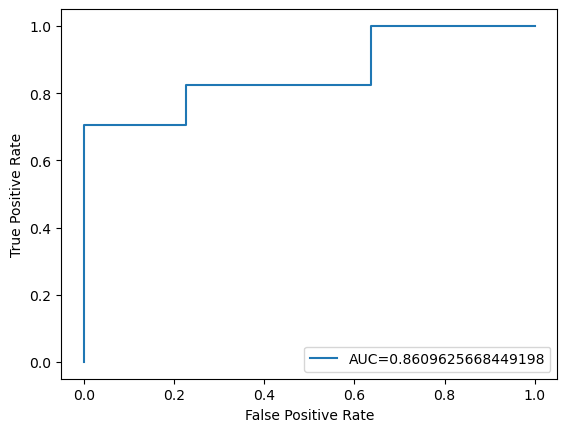

In [5]:
def microbiome_log_reg(data, predict, test_size):
    locations = pd.get_dummies(data["Location"]) # Won't actually be using this
    types = pd.get_dummies(data["Type"])
    y = types[predict]
    X = data.iloc[:, 3:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    lr = LogisticRegression()
    _ = lr.fit(X_train,y_train)
    y_pred_proba = lr.predict_proba(X_test)[::,1] 
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    return fpr, tpr, auc

def log_reg_auc(fpr, tpr, auc) -> None:
    plt.plot(fpr, tpr, label="AUC=" + str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()


p_fpr, p_tpr, p_auc = microbiome_log_reg(phyla, "Other", 0.3) # The model is basing its predictions on the relative abundances of 51 phyla 
# A couple of these are candidate phyla (the ones with the all-uppercase names) and a few aren't even prokaryotic
log_reg_auc(p_fpr, p_tpr, p_auc)



The model performance is adequate (> 0.85 AUC), but the flat stretches of false positive rate are rather long. Thus, there is a large trade-off with false positives if the model is to make correct predictions. The phylum-level taxonomic profiles of the different site types are probably too similar to allow classification.

- What if a lower taxonomic rank was used instead? Having a increased number of predictors should improve model accuracy


,sample.id,Location,Type,4-29-1,ABY1,AD3,AT-s3-28,Abditibacteria,Acidimicrobiia,Acidobacteriae,...,WPS-2,WS1,WS2,WS4,WWE3,Zixibacteria,Zygnematophyceae,bacteriap25,uncultured,vadinHA49
0,BrL1,Barrow Alaska Low,Permafrost,0.000150,0.000000,0.0,0.000000,0.000000,0.001564,0.054605,...,0.001895,0.0,0.0,0.000361,0.0,0.0,0.0,0.000000,0.001203,0.000181
1,BrL2,Barrow Alaska Low,Permafrost,0.001710,0.000406,0.0,0.000000,0.000203,0.000522,0.078533,...,0.000000,0.0,0.0,0.000551,0.0,0.0,0.0,0.000000,0.001855,0.000000
2,BrL3,Barrow Alaska Low,Permafrost,0.000281,0.000094,0.0,0.000000,0.000094,0.001714,0.055829,...,0.002151,0.0,0.0,0.000343,0.0,0.0,0.0,0.000000,0.001465,0.000000
3,BrL4,Barrow Alaska Low,Permafrost,0.001414,0.000231,0.0,0.000000,0.000000,0.000519,0.079433,...,0.000000,0.0,0.0,0.000462,0.0,0.0,0.0,0.000346,0.001587,0.000000
4,BrL5,Barrow Alaska Low,Permafrost,0.000086,0.000000,0.0,0.000069,0.000291,0.008034,0.123612,...,0.004882,0.0,0.0,0.000000,0.0,0.0,0.0,0.000206,0.001730,0.000274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,NzS6,Newzealand soil,Other,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.141794,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.009409,0.000000
126,NzS7,Newzealand soil,Other,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.142017,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.008931,0.000000
127,NzS8,Newzealand soil,Other,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.150907,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.008204,0.000000
128,NzS9,Newzealand soil,Other,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.139153,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.009939,0.000000


(130, 161)


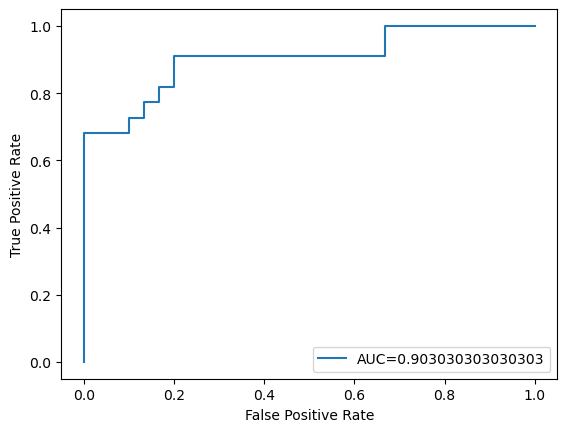

In [20]:
clss = pd.read_csv("./logistic_reg_class.csv")
display(clss)
print(clss.shape)
c_fpr, c_tpr, c_auc = microbiome_log_reg(clss, "Other", 0.4) # Predict using relative abundances of 161 classes
log_reg_auc(c_fpr, c_tpr, c_auc)
# AUC increases by 0.05 by moving down just one taxonomic rank. What about at the order level?

,sample.id,Location,Type,0319-6G20,11-24,4-29-1,AD3,AKIW659,AT-s3-28,Abditibacteriales,...,Zavarziniales,Zixibacteria,Zygnematophyceae,bacteriap25,eub62A3,mle1-27,mle1-8,uncultured,vadinBA26,vadinHA49
0,BrL1,Barrow Alaska Low,Permafrost,0.000730,0.000000,0.000159,0.0,0.000666,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.001681,0.000952,0.000190
1,BrL2,Barrow Alaska Low,Permafrost,0.000220,0.000126,0.001853,0.0,0.000000,0.000000,0.000220,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.007821,0.002481,0.000000
2,BrL3,Barrow Alaska Low,Permafrost,0.000460,0.000000,0.000295,0.0,0.000657,0.000000,0.000098,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000066,0.001937,0.001116,0.000000
3,BrL4,Barrow Alaska Low,Permafrost,0.000689,0.000156,0.001534,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000376,0.0,0.0,0.000094,0.006886,0.002160,0.000000
4,BrL5,Barrow Alaska Low,Permafrost,0.000690,0.000093,0.000093,0.0,0.000000,0.000075,0.000317,...,0.0,0.0,0.0,0.000224,0.0,0.0,0.000093,0.004606,0.001063,0.000298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,NzS6,Newzealand soil,Other,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.009786,0.000000,0.000000
126,NzS7,Newzealand soil,Other,0.000000,0.002479,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.009238,0.000000,0.000000
127,NzS8,Newzealand soil,Other,0.000000,0.003570,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.008478,0.000000,0.000000
128,NzS9,Newzealand soil,Other,0.000000,0.001120,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.010307,0.000000,0.000000


(130, 328)


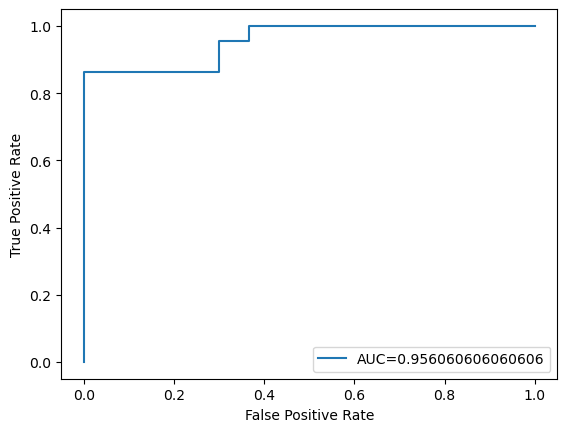

In [21]:
order = pd.read_csv("./logistic_reg_order.csv")
display(order)
print(order.shape)
o_fpr, o_tpr, o_auc = microbiome_log_reg(order, "Other", 0.4) # Predict using relative abundances of 328 microbial orders
log_reg_auc(o_fpr, o_tpr, o_auc)
# Another ~0.05 increase in AUC

- As expected, increasing taxonomic resolution produces better and better logistic regression models. Of course, there is a tradeoff in that the tools used to classify OTUs are less accurate at predicting lower taxonomic ranks.
  - Another issue is that the sheer scale of microbial diversity means that a LOT of environmental data would be needed to obtain precise predictions. This data would also need to include all possible types of microbiomes in the area, such as different depths of soil
  - Microbiomes can also change on a temporal scale, so data collected at one point in time would be an inaccurate representation of the place at another time
- A growing field that makes use of taxonomic profiles to identify locations is microbial forensics. Being able to know precisely where something came just by sequencing the bacteria on its surface is clearly useful, but the challenges mentioned (and many others) need to be overcome before the approach sees widespread use